In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

Исходная краевая задача:
$$
y'' - x\sqrt{y} = 0,\;\;\;0 \leq x \leq 1\\
y(0) = 0, \;\;y(1) = 2
$$
Решим её методом пристрелки. 
Поставленная задача имеет вид
$$
y'' = f(x, y, y'), \;\;\; 0 \leq x \leq 1\\
y(0) = Y_0,\\
y(1) = Y_1
$$
Уже есть удобные методы для решения задачи Коши вида:  
$$
y'' = f(x, y, y'), \;\;\; 0 \leq x \leq 1\\
y(0) = Y_0,\\
y'(0) = \alpha
$$
Здесь $Y_0$ - ордината точки, из которой выходит интегральная кривая, $\alpha$ - пристрелочный параметр, определяющий угол наклона интегральной кривой к оси $x$ при выходе их точки $(0, Y_0)$. При фиксированном $Y_0$ решение ЗК будет зависеть от пристрелочного параметра, $y = y(x, \alpha)$. При $x = 1$ решение зависит только от $\alpha$:  
$$y(x, \alpha)|_{x = 1} = y(1, \alpha)$$
Тогда ЗК можно переформулировать: найти $\alpha = \alpha^*$, т.ч.  
$$ y(1, \alpha) = Y_1. $$
Значит, надо решить уравнение вида $F(\alpha) = 0$, где $F(\alpha) = y(1, \alpha) - Y_1$.  
Т.е.  
$$
F(\alpha) = y(1, \alpha) - 2\\
y(0) = 0, y'(0) = \alpha\\
$$

### Алгоритм
Берём начальное значение $\alpha_0$, например из условия $\alpha_0 = \frac{Y_1 - Y_0}{1 - 0} = 2$.  
Надо решить ЗК  
$$
y'' = x\sqrt{y}\\
y(0) = 0\\
y'(0) = \alpha_0 = 2
$$   
Сводим к системе:  
$$
y' = z,\;y(0) = 0\\
z' = x \sqrt{y},\;z(0) = 2
$$
Решаем методом Эйлера с шагом h:  
$$
y_{i + 1} = y_i + h \cdot z_i\\
z_{i + 1} = z_i + h \cdot x_i \cdot \sqrt{y} 
$$
Вычисляем $$
F(\alpha_n) = y(1, \alpha_n) - 2,\\
F'(\alpha_n) = \frac{F(\alpha_n + h) - F(\alpha_n)}h
$$
Проверяем, подходит ли нам такое $\alpha$: если $|F(1, \alpha_n)| < \varepsilon$, завершаем поиск решения.  
Если условие не выполянется, делаем шаг по $\alpha$:  
$$
\alpha_{n + 1} = \alpha_n - \frac{F(\alpha_n)}{F'(\alpha_n)}
$$
Повторяем, пока не будет найдено нужное $\alpha$.

In [2]:
def image(a1, a2):
    fig, ax = plt.subplots()
    ax.plot(a1, a2, '.')
    ax.grid()
    plt.show()

### Реализация решения задачи Коши
Регаем задачу Коши 2-го порядка, имеющую вид
$$
y'' = f(x, y, y')\\
y(L_1) = A,\;\;\; y'(L_2) = B
$$
Расщепляем на 2 задачи Коши 1-го порядка (заменой $z = y'$):
$$
z' = f(x, y, z),\;\;\;z(L_2) = B\\
y' = z, \;\;\;y(L_1) = A
$$
Решаем их совместно по схеме Эйлера.

In [3]:
class Cauchy_problem:
    def __init__(self, alpha, beta, L1, L2, f):
        self.alpha, self.L1, self.L2, self.f = alpha, L1, L2, f
        self.beta = beta
        
    def z_(self, x, y, z):
        return self.f.subs({symbols('x'): x, symbols('y'): y, symbols('z'): z})

    def y_iteration(self, y, z, h):
        return y + h * z

    def z_iteration(self, x, y, z, h):
        return z + h * self.z_(x, y, z)

    def solve_ZK(self):
        N = 20
        h = (self.L2 - self.L1) / N
        arr_x, arr_y = [], []

        x0, y0, z0 = self.L1, self.beta, self.alpha
        x, y, z = x0, y0, z0
        arr_x.append(x0)
        arr_y.append(y0)

        for i in range(N):
            y_new = self.y_iteration(y, z, h)
            z_new = self.z_iteration(x, y, z, h)
            x_new = x + h
            x, y, z = x_new, y_new, z_new
            arr_x.append(x)
            arr_y.append(y)
        self.x, self.y = arr_x, arr_y
        
    def print_solution(self):
        print('Решение на отрезке [0, ' + str(L2) + ']:')
        for i in range(len(self.x)):
            print('y(' + str(round(self.x[i], 2)) + ') = ', round(self.y[i], 5))
        
    def solve(self):
        self.solve_ZK()
        self.print_solution()
        image(self.x, self.y)

### Реализация метода пристрелки
Решаем задачу  Коши вида:
$$
y'' = f(x, y, y'),\\
y(L_1) = A,\;\;\;y'(L_2) = \alpha
$$
Подбираем $\alpha$ до тех пор, пока с нужной точностью не удовлетворится условие:
$$
\left|{y(L_2, \alpha) - B}\right| < \varepsilon
$$

In [4]:
class shooting_procedure:
    def __init__(self, f, L1, L2, A, B):
        self.M = 5
        self.L1, self.L2 = L1, L2
        self.f = f
        self.A, self.B = A, B
        return
    
    def y(self, alpha):
        S = Cauchy_problem(alpha, self.A, self.L1, self.L2, self.f)
        S.solve_ZK()
        return S.y[len(S.y) - 1]

    def F(self, alpha):
        return self.y(alpha) - self.B

    def der_F(self, al):
        h = 1e-3
        return (self.F(al + h) - self.F(al)) / h

    def alpha_(self, al):
        return al - self.F(al) / self.der_F(al)
    
    def print_solution(self):
        print('Количество итераций поиска альфы =', self.i)
        for i in range(len(self.x)):
            print('y(' + str(round(self.x[i], 2)) + ') = ', round(self.y[i], self.M))
    
    def shooting(self):
        eps = 10 ** (-self.M)
        alpha = (self.B - self.A) / (self.L2 - self.L1)
        i = 0
        while 1:
            i += 1
            if abs(self.F(alpha)) > eps:
                alpha = self.alpha_(alpha)
            else:
                b = False
                S = Cauchy_problem(alpha, self.A, self.L1, self.L2, self.f)
                S.solve_ZK()
                self.x, self.y = S.x, S.y
                self.i = i
                self.alpha = alpha
                return
    
    def shoot(self):
        self.shooting()
        self.print_solution()
        image(self.x, self.y)

Количество итераций поиска альфы = 3
y(0) =  0
y(0.05) =  0.09343
y(0.1) =  0.18687
y(0.15) =  0.28034
y(0.2) =  0.37392
y(0.25) =  0.46770
y(0.3) =  0.56179
y(0.35) =  0.65630
y(0.4) =  0.75138
y(0.45) =  0.84716
y(0.5) =  0.94381
y(0.55) =  1.04150
y(0.6) =  1.14040
y(0.65) =  1.24070
y(0.7) =  1.34260
y(0.75) =  1.44632
y(0.8) =  1.55206
y(0.85) =  1.66006
y(0.9) =  1.77055
y(0.95) =  1.88378
y(1.0) =  2.00000000000000


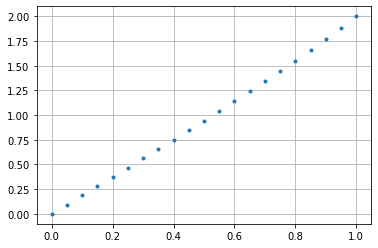

In [5]:
# Задание функции z = f(x, y, z)
x, y, z = symbols('x y z')
f = x * sqrt(y)

# Задание параметров задачи
A, B = 0, 2
L1, L2 = 0, 1

P = shooting_procedure(f, L1, L2, A, B)
P.shoot()

### Интерполяция

In [6]:
class interpolant:
    def __init__(self, x_, f_):
        self.x, self.f, self.P_Newton = x_, f_, 0
        
    def interpolation(self):
        P = 0
        for k in range(len(self.x)):
            l = 1
            for i in range(len(self.x)):
                if i != k:
                    l *= (x - self.x[i]) / (self.x[k] - self.x[i])
            P += l * self.f[k]
        self.P_Newton = P
        
    def printing(self, s):
        if s == 'Newton':
            print('Интерполянт методом Ньютона:')
            display(Eq(symbols('P'), simplify(self.P_Newton)))
        
    def image(self, s):
        p = []
        x__ = np.linspace(float(min(self.x)), float(max(self.x)), num = len(self.x) * 4)
        if s == 'Newton':
            for i in range(len(x__)):
                p.append(self.P_Newton.subs({x: x__[i]}))
            color_ = 'blue'
            
        fig, ax = plt.subplots()
        ax.plot(x__, p, '--', label = 'интерполяция', color = color_)
        ax.plot(self.x, self.f, '.', label = 'исходные данные', color = 'red')
        ax.set_title(s, fontfamily = 'fantasy', size = 16)
        ax.legend()
        ax.grid()
        plt.show()

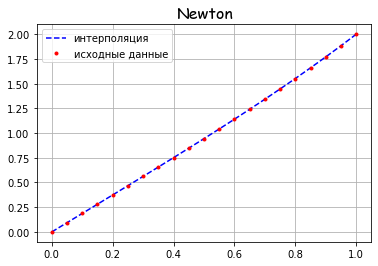

In [7]:
I = interpolant(P.x, P.y)
I.interpolation()
I.image('Newton')

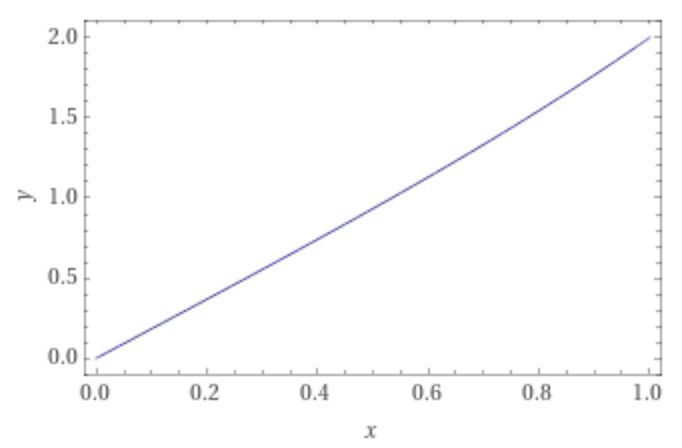